# HMASR 1°x1° DNN calibration
Training in `HMASR_100km_ML3.ipynb` notebook

Env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
# phd_v3 env
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load data

In [2]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
scf= ds.SCA_Post.load()

# Mask
mask = xr.open_dataarray('Non_seasonal_snow_mask_100km.nc').load()

# Topo
latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset('../data/HMASR_DEM_100km.nc')
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

train_period = slice('1999-10-01', '2013-09-30') # ~80%
val_period = slice('2013-10-01', '2017-09-30') # ~20%

## Make plot functions

### Compute weights
Taking into account:
- cos(lat)
- fraction of seasonal snow in a grid cell
- exclude cells with >30% of permanent snow

Weigths used to compute metrics (but not for optimization? -> maybe)

In [3]:
lat_weights = np.cos(np.deg2rad(scf.lat))
frac_seasonal_snow = (1-mask/100).where(scf[0]*0+1 == 1)
temp = (frac_seasonal_snow*lat_weights).where(mask<30)
weights = (temp / temp.sum()).fillna(0)
np.testing.assert_equal(weights.sum().values.item(0), 1)

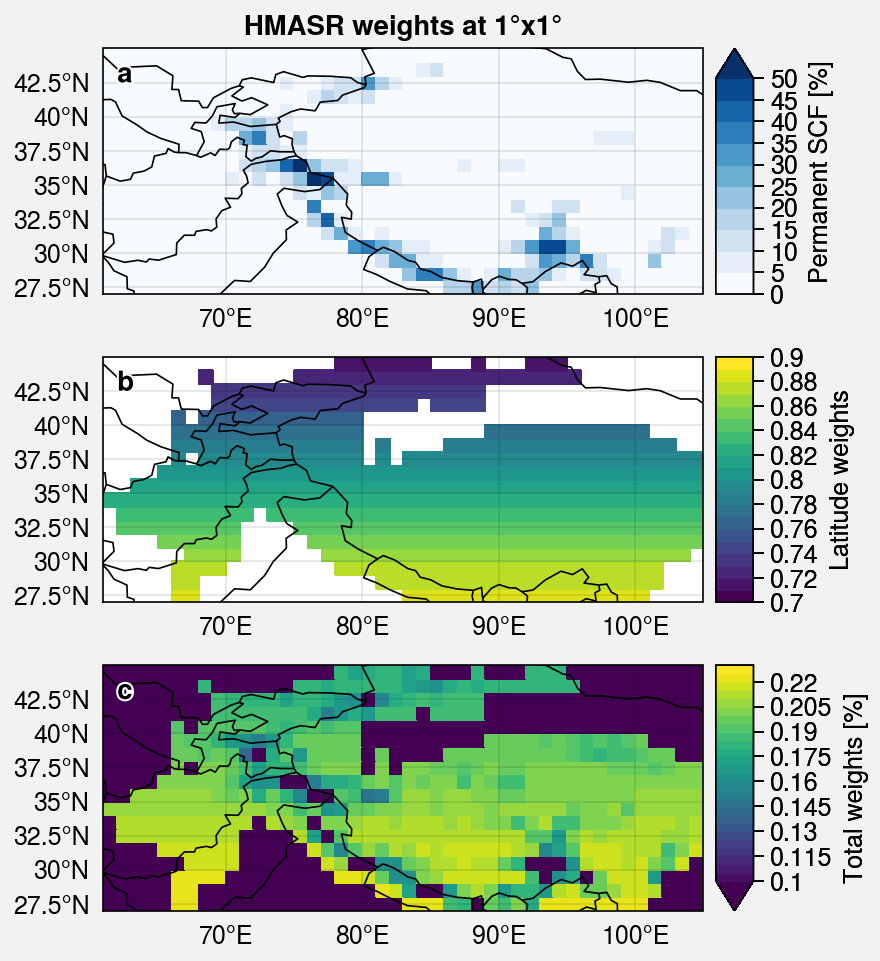

In [4]:
fig, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=3)

threshold = 30 # percentage of permanent snow in a cell

axs[0].pcolormesh(mask, levels=plot.arange(0, 50, 5), extend='max', cmap='Blues',
                 colorbar='r', colorbar_kw={'label': 'Permanent SCF [%]'})

axs[1].pcolormesh((scf[0]*0+1)*lat_weights, levels=plot.arange(0.7, 0.9, 0.01), cmap='viridis',
                 colorbar='r', colorbar_kw={'label': 'Latitude weights'})

axs[2].pcolormesh(weights*100, levels=plot.arange(0.0010, 0.0023, 0.00005)*100, cmap='viridis', extend='min',
                 colorbar='r', colorbar_kw={'label': 'Total weights [%]'})

# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    suptitle='HMASR weights at 1°x1°',
    abc=True, abcloc='ul'
)

# fig.save('img/weights.jpg')

### Check zones

In [5]:
# Get zone limits for annual cycle
lonlim_TS, latlim_TS, lonlim_HK, latlim_HK, lonlim_TP, latlim_TP, lonlim_HM, latlim_HM = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'TS', 'HK', 'TP', 'HM']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_TS, latlim_TS], [lonlim_HK, latlim_HK], [lonlim_TP, latlim_TP], [lonlim_HM, latlim_HM]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

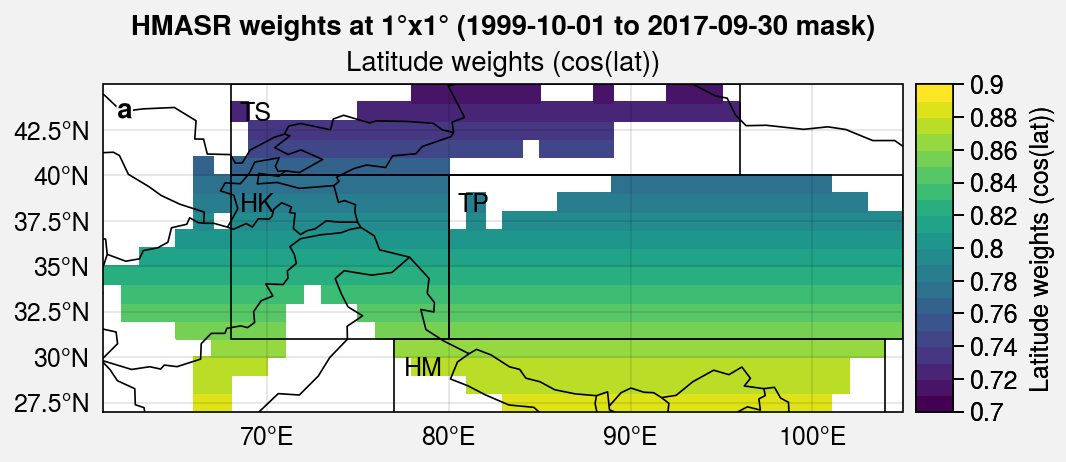

In [6]:
fig, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=4)

threshold = 30 # percentage of permanent snow in a cell

axs[0].pcolormesh(((scf[0]*0+1)*lat_weights), 
                  levels=plot.arange(0.7, 0.9, 0.01), cmap='viridis',
                 colorbar='r', colorbar_kw={'label': 'Latitude weights (cos(lat))'})
axs[0].format(title='Latitude weights (cos(lat))')

u.plot_zones(axs[0])

# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    suptitle='HMASR weights at 1°x1° (1999-10-01 to 2017-09-30 mask)',
    abc=True, abcloc='ul'
)

## DNN (this paper)
Training in `HMASR_100km_ML3.ipynb` notebook


In [7]:
scf_ML3 = xr.open_dataarray('results/scf_100km_ML3.nc')

In [8]:
w = scf.copy(); w[:] = weights
mse = u.weighted_rmse(scf.sel(time=train_period), scf_ML3.sel(time=train_period), w.sel(time=train_period))**2
print('MSE = {:0.3f}'.format(mse.item(0)) + ' / RMSE = {:0.3f}'.format(np.sqrt(mse.item(0))) + ' ({:0.1f} %)'.format(np.sqrt(mse.item(0))*100))

MSE = 0.005 / RMSE = 0.070 (7.0 %)


In [9]:
w = scf.copy(); w[:] = weights
mse = u.weighted_rmse(scf.sel(time=val_period), scf_ML3.sel(time=val_period), w.sel(time=val_period))**2
print('MSE = {:0.3f}'.format(mse.item(0)) + ' / RMSE = {:0.3f}'.format(np.sqrt(mse.item(0))) + ' ({:0.1f} %)'.format(np.sqrt(mse.item(0))*100))

MSE = 0.005 / RMSE = 0.071 (7.1 %)


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


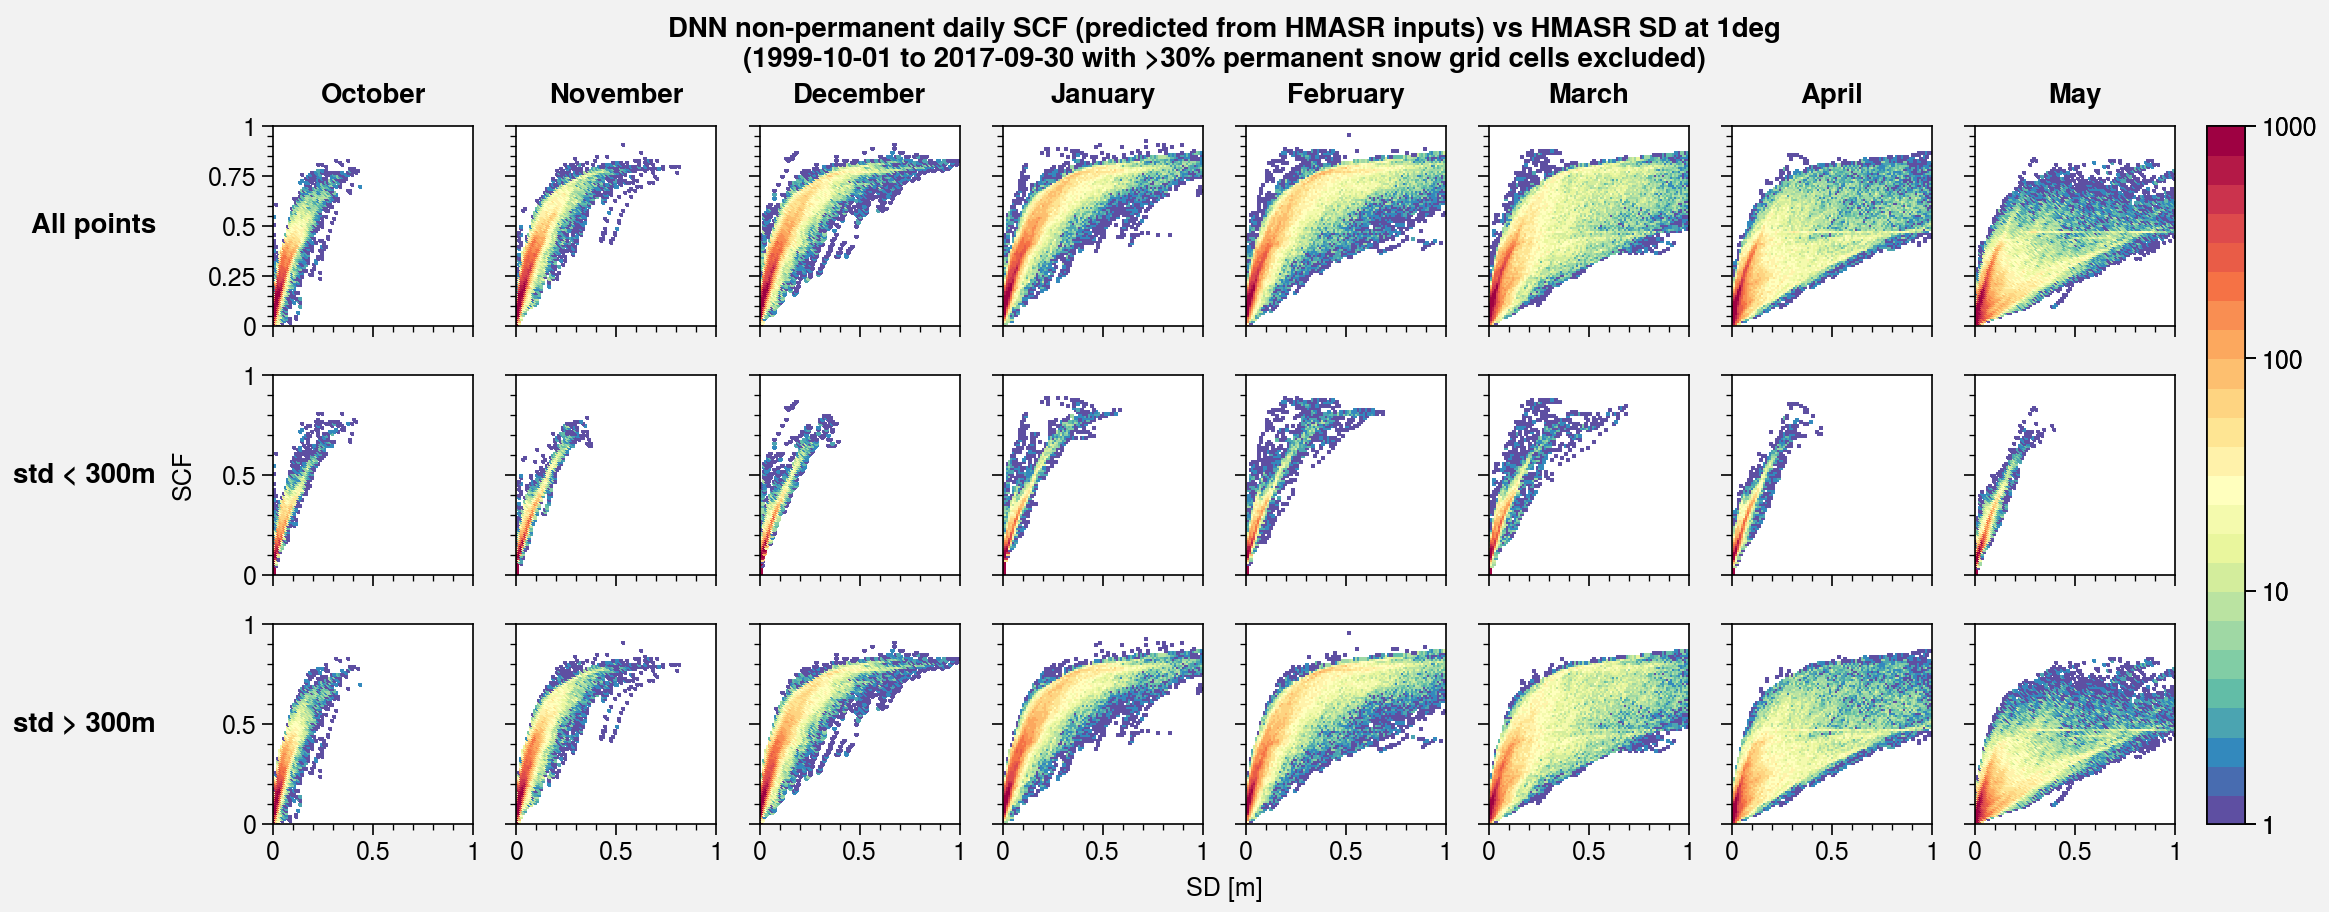

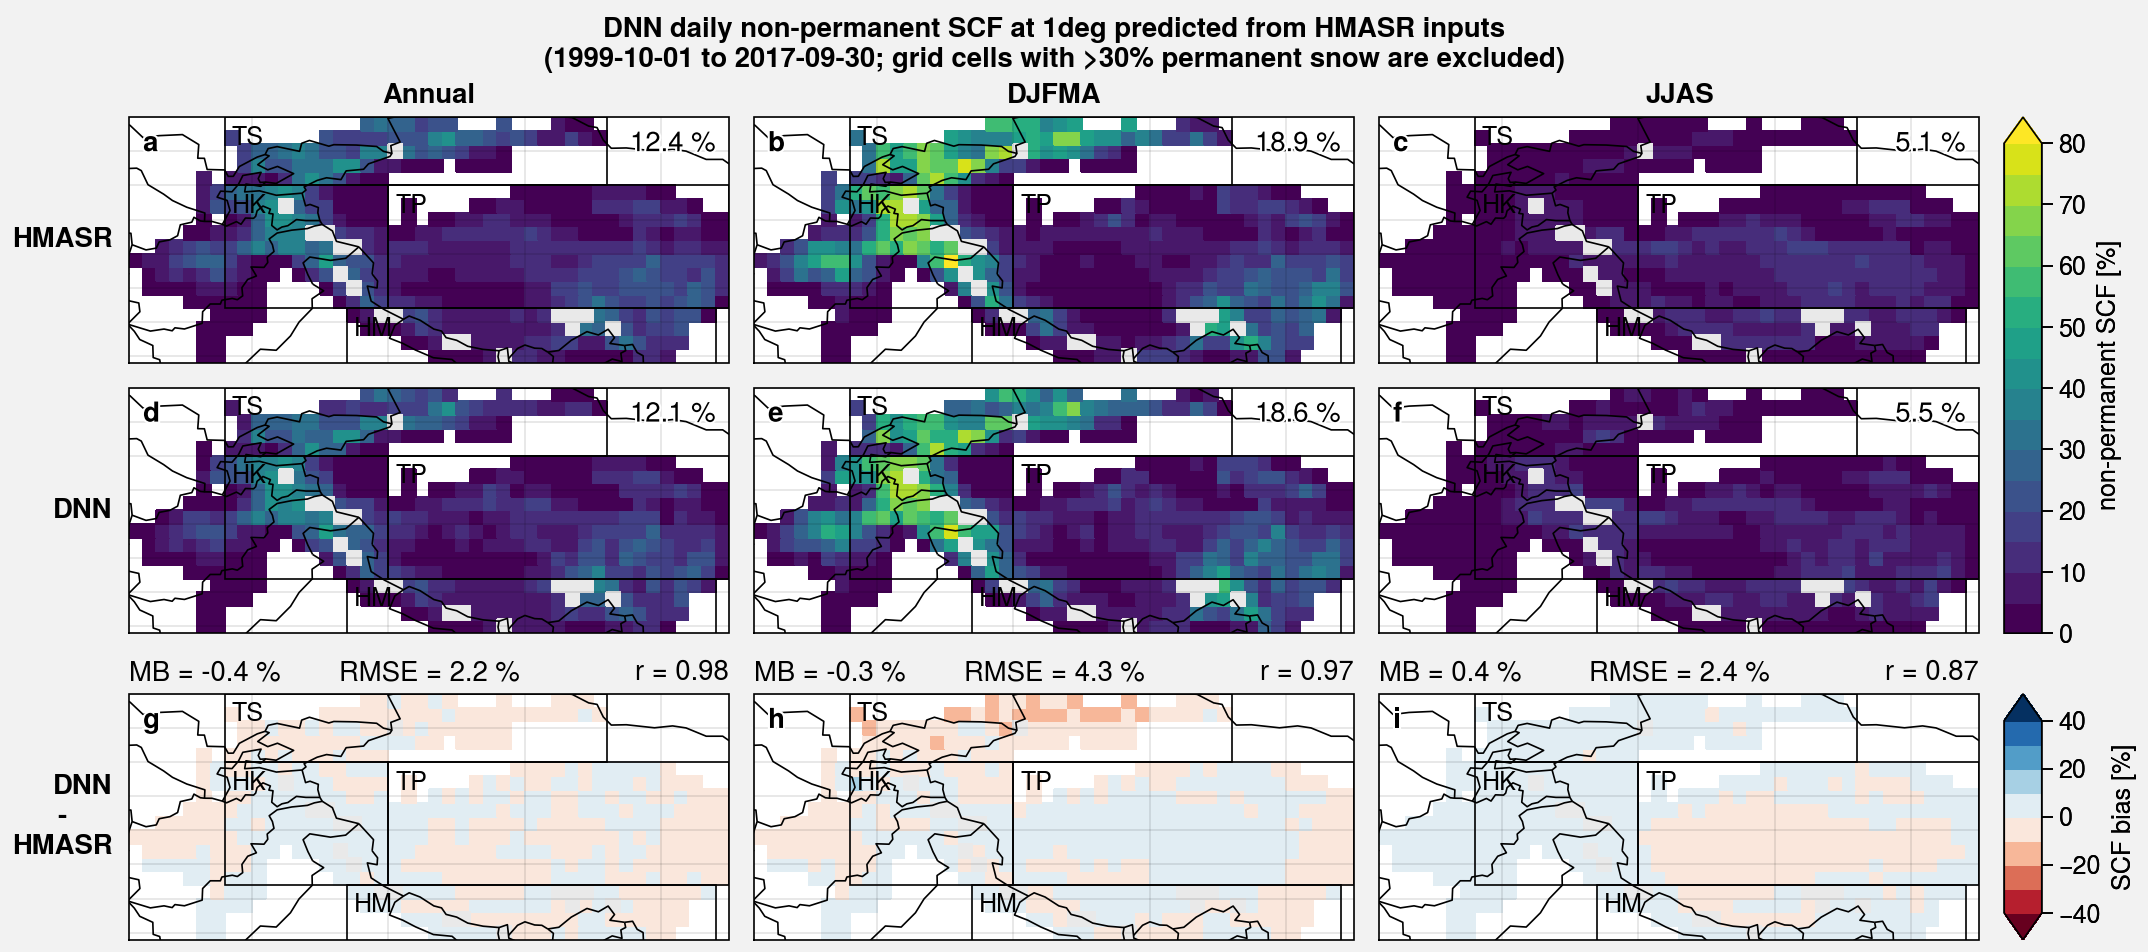

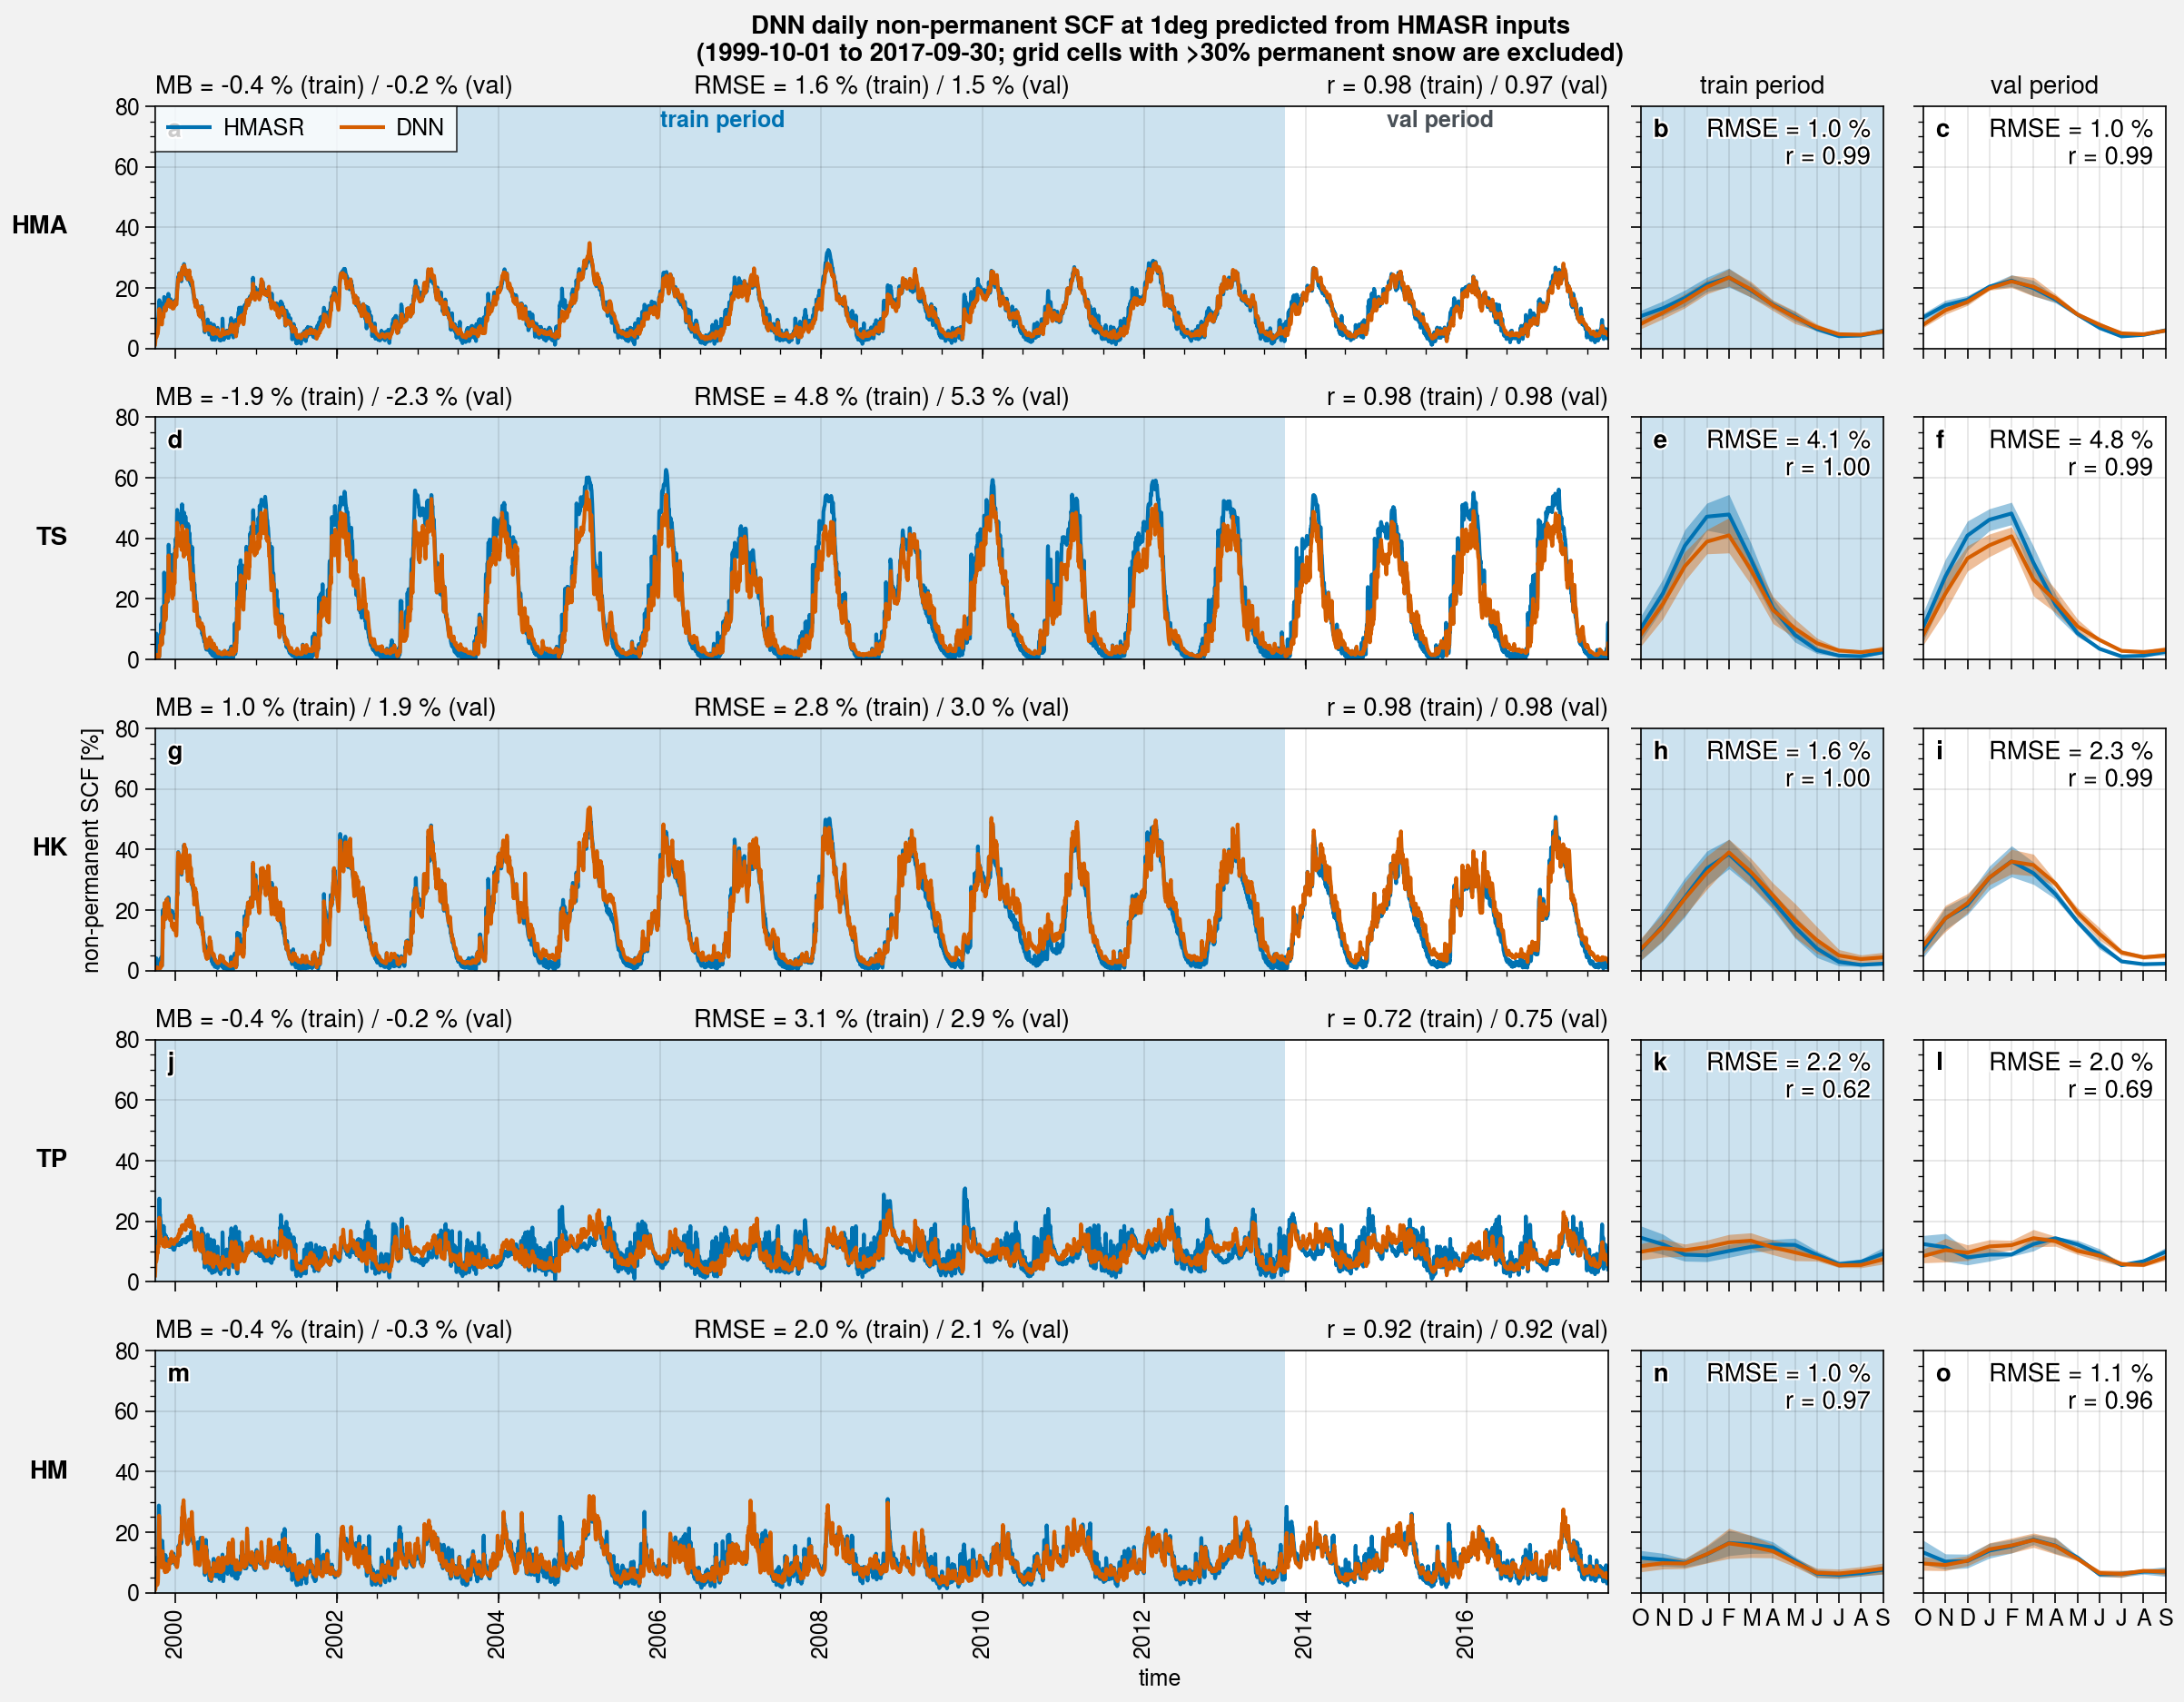

In [10]:
u.plots(scf, sd, scf_ML3, topo_std, mask, weights, zones_df, 'DNN', '1deg', y_max=80, save=False)